In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import (LinearSVC, SVC)
from sklearn.linear_model import (SGDClassifier, LogisticRegression)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/raw/churn.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

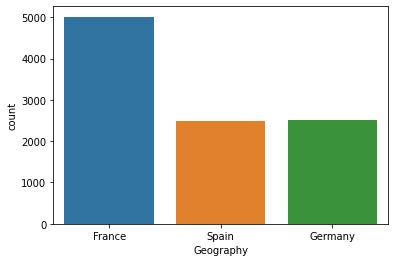

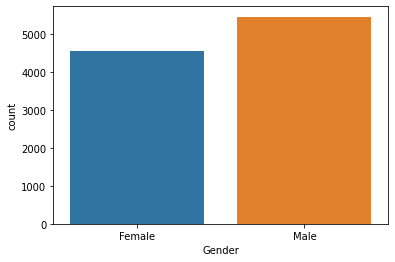

In [5]:
def plot_categorical(column):
    fig = plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=column)
    plt.show()

for x in df.select_dtypes(include='object').columns:
    plot_categorical(x)

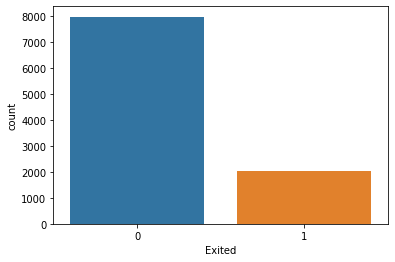

In [6]:
sns.countplot(data=df, x=df['Exited'])

In [7]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Female' else 0)
df = pd.get_dummies(df)

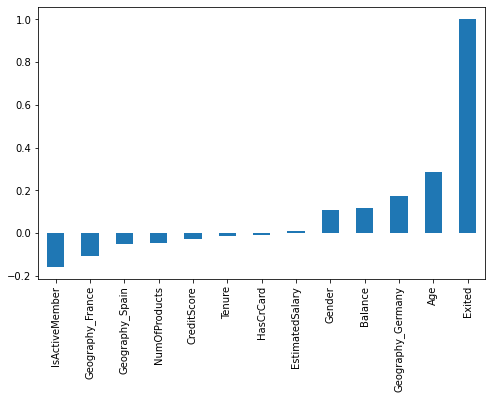

In [8]:
plt.figure(figsize=(8,5))
df.corr()['Exited'].sort_values(ascending=True).plot(kind='bar')
plt.show()

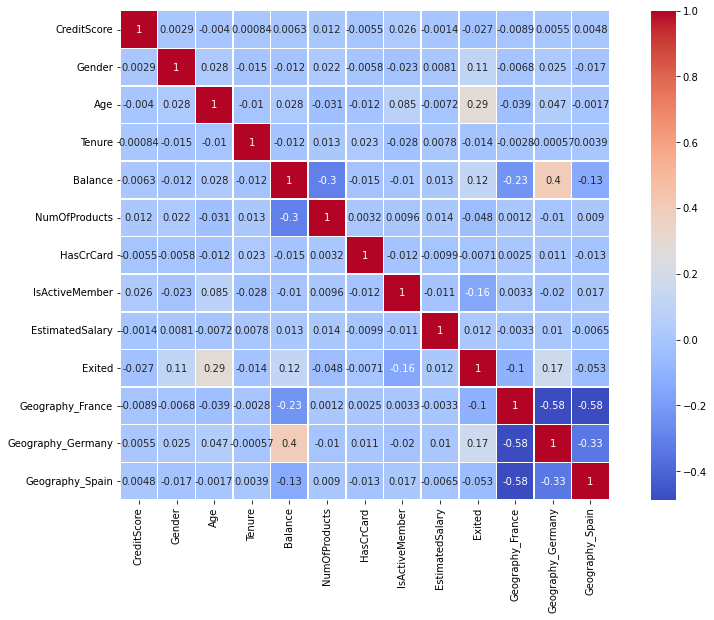

In [9]:
plt.figure(figsize=(15,9))
sns.heatmap(data=df.corr(), annot=True, linewidths=.5, square=True, cmap='coolwarm', robust=True)
plt.show()

In [10]:
x = df.drop('Exited', axis=1)
y = df['Exited']

In [11]:
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x, y)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, train_size=0.8, random_state=42, shuffle=True)

In [13]:
scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
pickle.dump(scaler, open("models/version2.0_MateoSanchez/scaler.pk", "wb"))

Seleccion del modelo

In [15]:
def test_models(models, parameters=None, met_bag=False, k_cv=3):    
    results = []
    columns = ['Model', 'Accuracy', 'Precision Churn=NO', 'Precision Churn=YES', 'Best params']
    for name, estimator in models.items(): 
        if parameters != None:
            grid = GridSearchCV(estimator, parameters[name], cv=k_cv, scoring='accuracy').fit(x_train, y_train)
            y_pred = grid.predict(x_test)
            best_par = grid.best_params_
            
        else:
            if met_bag == True: 
                bag = BaggingClassifier(base_estimator=estimator).fit(x_train, y_train)
                y_pred = bag.predict(x_test)
            else:
                model = estimator.fit(x_train, y_train)
                y_pred = model.predict(x_test)
            best_par=None

        accu = metrics.accuracy_score(y_pred, y_test)
        pres = metrics.precision_score(y_pred, y_test, average=None)        
        results.append([name, accu, pres[0], pres[1], best_par])

    results = pd.DataFrame(results, columns=columns).dropna(axis=1)
    results = results.sort_values('Accuracy', ascending=False).reset_index(drop=True)

    if parameters != None: results = [results, grid.best_estimator_]
    return results

In [17]:
models_only = {
    'KNeighbors': KNeighborsClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSCV': LinearSVC(),
    'SVC': SVC(),
    'SGDC': SGDClassifier(),
    'RandomTreeForest' : RandomForestClassifier(),
    'Boosting' : GradientBoostingClassifier()
    }

results_only = test_models(models_only)

results_only.to_csv('data/results/resultados_only_models.csv', index=False)

In [18]:
results_only

,Model,Accuracy,Precision Churn=NO,Precision Churn=YES
0,RandomTreeForest,0.889831,0.902633,0.876368
1,SVC,0.866918,0.899571,0.832582
2,Boosting,0.865035,0.884874,0.844173
3,KNeighbors,0.841808,0.849969,0.833226
4,LinearSCV,0.816698,0.855481,0.775918
5,LogisticRegression,0.815129,0.853644,0.774630
6,SGDC,0.805399,0.904470,0.701223


In [19]:
models_bag = {
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomTreeForest' : RandomForestClassifier(),
    'Boosting' : GradientBoostingClassifier()
    }

results_bag = test_models(models_bag, met_bag=True)

results_bag.to_csv('data/results/resultados_bagg_models.csv', index=False)

In [20]:
results_bag

,Model,Accuracy,Precision Churn=NO,Precision Churn=YES
0,RandomTreeForest,0.886064,0.898347,0.873149
1,Boosting,0.868801,0.886099,0.850612
2,SVC,0.867232,0.904470,0.828075
3,KNeighbors,0.845574,0.860380,0.830006


In [21]:
models_grid = {
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomTreeForest' : RandomForestClassifier(),
    'Boosting' : GradientBoostingClassifier()
    }

parameters_grid = {'KNeighbors': {"n_neighbors" : range(3,11,1)},

            'SVC':{"C" : [0.5, 1.5, 0.1],
                "kernel" :  ['linear', 'poly', 'rbf']},

            'RandomTreeForest' : {"n_estimators" : range(50, 150, 10),
                "criterion" : ["gini", "entropy"],
                "max_depth" : range(3, 11)},
              
            'Boosting' : {"max_depth": range(3, 11)}
            }

grid = test_models(models_grid, parameters=parameters_grid, k_cv=5)
results_grid, best_model = grid[0], grid[1]

In [22]:
pickle.dump(best_model, open("models/version2.0_MateoSanchezmodel.pk", "wb"))
results_grid.to_csv('data/results/resultados_grid_models.csv', index=False)

In [23]:
print(best_model)
results_grid

GradientBoostingClassifier(max_depth=10)


,Model,Accuracy,Precision Churn=NO,Precision Churn=YES,Best params
0,Boosting,0.892028,0.906920,0.876368,{'max_depth': 10}
1,RandomTreeForest,0.869743,0.883650,0.855119,"{'criterion': 'entropy', 'max_depth': 10, 'n_e..."
2,SVC,0.866604,0.897734,0.833870,"{'C': 1.5, 'kernel': 'rbf'}"
3,KNeighbors,0.841808,0.849969,0.833226,{'n_neighbors': 5}


Text(0.5, 15.0, 'Predict label')

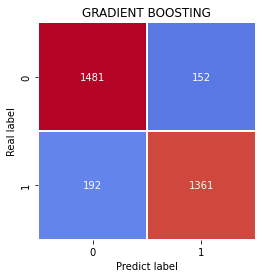

In [24]:
cm = confusion_matrix(y_test, best_model.predict(x_test))
plt.figure(figsize=(4,4))
plt.title('GRADIENT BOOSTING')
sns.heatmap(cm, annot=True, vmin=0, fmt='.0f', cbar=False, linewidths=.5, square=True, cmap='coolwarm')
plt.ylabel('Real label')
plt.xlabel('Predict label')